In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import t as t_dist
plt.rcParams['font.family'] = 'Ubuntu'

from data_processing.functions import combine_summary_dataframes

### Some functions definitions

## Req/s (batch) plots and calculations (from summary dataframe)

In [2]:
def xor_columns_ratios(input_df, error_column="Req/s_error"):
    # List to collect results
    results = []
    to_ratio_column = "Req/s_mean"
    # Group by algorithm
    for alg, alg_group in input_df.groupby("algorithm"):
        # Extract modes without '-xor' 
        base_modes = [mode for mode in alg_group["mode"].unique() if "-xor" not in mode]

        # For each base mode, check if it has a corresponding -xor mode
        for base_mode in base_modes:
            if f"{base_mode}-xor" in alg_group["mode"].values:
                base_row = alg_group[alg_group["mode"] == base_mode].iloc[0]
                xor_row = alg_group[alg_group["mode"] == f"{base_mode}-xor"].iloc[0]

                # Calculate ratio
                ratio = base_row[to_ratio_column] / xor_row[to_ratio_column]

                # Calculate error using propagation of errors formula for division
                error = ratio * ((xor_row[error_column] / xor_row[to_ratio_column])**2 + 
                                 (base_row[error_column] / base_row[to_ratio_column])**2)**0.5

                results.append({"algorithm": alg, "mode": base_mode, "xor_ratio": ratio, "xor_error": error})

    # Convert list of dictionaries to DataFrame
    output_df = pd.DataFrame(results)

    return output_df

In [4]:
def plot_req_s(input_df, error_column="Req/s_std", several_runs=True, xor_ratios=False, n_clients=None, n_requests=None, plot_title="req_s.png", y_start=None):
    """
    Plots requests per second and optionally data per second for different algorithms and modes.

    :param input_df: DataFrame containing the data to be plotted, with columns for algorithm, mode, Req/s, etc.
    :param several_runs: Boolean, if True, the mean values are plotted and error bars represent standard deviation. Default is True.
    :param xor_ratios: Boolean, if True, the XOR ratios are computed and plotted as subplot. Default is False.
    :param n_clients: Integer, number of clients used, for labeling purposes.
    :param n_requests: Integer, number of requests used, for labeling purposes.
    """
    def mode_order(mode):
        if "qrandom" in mode:
            return 0
        elif "rngtools" in mode:
            return 1
        else:
            return 2

    if several_runs:
        column_suffix = "_mean"
    else:
        column_suffix = ""

    width = 0.15  # width of the bars
    input_df = input_df.sort_values('algorithm')

    algorithms = input_df["algorithm"].unique()
    x = np.arange(len(algorithms))  # label locations
    mode_data = input_df["mode"].unique()
    req_s_column = f"Req/s{column_suffix}"

    mode_data = sorted(mode_data, key=lambda mode: input_df[input_df["mode"] == mode][req_s_column].mean(), reverse=False)

    color_palette = list(mcolors.LinearSegmentedColormap.from_list("", ["#9fcf69", "#33acdc"])(np.linspace(0, 1, len(mode_data))))

    if xor_ratios:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        ratio_df = xor_columns_ratios(input_df)
        scatter_y_positions = np.linspace(0, len(algorithms)-1, len(algorithms))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
        input_df = input_df[~input_df["algorithm"].str.contains("frodo|bike|hqc")]


    scatter_plots = []
    base_modes = []

    for i, mode in enumerate(mode_data):
        mode_df = input_df[input_df["mode"] == mode]
        x_position = x - (3/2)*width + i*width

        if xor_ratios:
            bars_container = axes[0].bar(
                x_position,
                mode_df[req_s_column],
                width,
                label=mode,
                zorder=3,
                color=color_palette[i],
                edgecolor='black',
                linewidth=1,
                yerr=mode_df[error_column] if several_runs else None,
                capsize=3,
                error_kw={'ecolor': 'black'}
                )
            if several_runs:
                for line in bars_container.errorbar.lines[2]:
                    line.set_linestyle('dashed')
                    line.set_linewidth(0.75)
            
            if "-xor" in mode:
                base_mode = mode.replace("-xor", "")
                mode_ratios = ratio_df[(ratio_df["algorithm"].isin(algorithms)) & (ratio_df["mode"] == base_mode)]
                # set line width to 1
                axes[1].axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.75)
                #axes[1].errorbar(x_position, mode_ratios["xor_ratio"], yerr=mode_ratios["xor_error"], fmt='none', color="black", capsize=3, zorder=4, linestyle="dashed")

                scatter_errors = axes[1].errorbar(
                    x_position + width/2, 
                    mode_ratios["xor_ratio"], 
                    yerr=mode_ratios["xor_error"], 
                    fmt='none',  
                    color="black", 
                    capsize=3, 
                    zorder=4, 
                    label=f"{base_mode} XOR Ratio"
                )

                for line in scatter_errors.lines[2]:
                    line.set_linestyle('dashed')
                    line.set_linewidth(0.75)
                scatter_plot = axes[1].scatter(x_position + width/2, mode_ratios["xor_ratio"], marker='o', color=color_palette[i], zorder=4, s=20, label=f"{base_mode} XOR Ratio")
                scatter_plots.append(scatter_plot)
                base_modes.append(base_mode)

        else:
            container = axes.bar(
                x_position,
                mode_df[req_s_column],
                width,
                label=mode,
                zorder=3,
                color=color_palette[i],
                edgecolor='black',
                linewidth=1,
                yerr=mode_df[error_column] if several_runs else None,
                capsize=3,
                error_kw={'ecolor': 'black'}
                )
            if several_runs:
                for line in container.errorbar.lines[2]:
                    line.set_linestyle('dashed')
                    line.set_linewidth(0.75)

    if xor_ratios:
        axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(mode_data), frameon=False, fontsize=11)
        axes[1].legend(handles=scatter_plots, labels=base_modes, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(scatter_plots), frameon=False, fontsize=11)
    else:
        if len(mode_data) <= 3:
            axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(mode_data), frameon=False, fontsize=11)
        else:
            axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=False, fontsize=11)

    if xor_ratios:
        axes[0].set_ylabel('Req/s', weight='bold', fontsize=12)
        axes[0].set_title(f'Req/s by algorithm', weight='bold', y=1.10)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(algorithms, rotation=45, horizontalalignment='right')
        axes[0].tick_params(axis='both', labelsize=11)
        axes[0].yaxis.set_label_coords(-0.04, 0.5)
        if y_start is not None:
            axes[0].set_ylim(y_start, None)
        axes[1].set_ylabel('Ratio', weight='bold', fontsize=12)
        axes[1].set_title(f'XOR/no-XOR ratios by algorithm', weight='bold', y=1.10)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(algorithms, rotation=45, horizontalalignment='right')
        axes[1].tick_params(axis='both', labelsize=11)
        axes[1].yaxis.set_label_coords(-0.04, 0.5)
    else:
        axes.set_ylabel('Req/s', weight='bold', fontsize=12)
        axes.yaxis.set_label_coords(-0.065, 0.5)
        axes.set_xticks(x)
        axes.set_xticklabels(algorithms, rotation=45, horizontalalignment='right')
        axes.tick_params(axis='both', labelsize=11)

    plt.xlabel('Algorithm', weight='bold', fontsize=12)

    if xor_ratios:
        axes[0].yaxis.set_minor_locator(AutoMinorLocator())
        axes[0].xaxis.set_minor_locator(AutoMinorLocator())
        axes[0].grid(True, zorder=0, alpha=0.5)
        axes[0].grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)
        axes[1].yaxis.set_minor_locator(AutoMinorLocator())
        axes[1].xaxis.set_minor_locator(AutoMinorLocator())
        axes[1].grid(True, zorder=0, alpha=0.5)
        axes[1].grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)
    else:
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        axes.grid(True, zorder=0, alpha=0.5)
        axes.grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)

    if not xor_ratios and y_start is not None:
       axes.set_ylim(y_start, None)
       

    plt.tight_layout()

    if not os.path.isdir("./plots"):
        os.mkdir("./plots")

    plt.savefig(os.path.join(".", "plots", plot_title))
    plt.show()


#### Plotting QRNG no-QRNG Req/s comparison

In [5]:
n_clients = 1000
n_requests = 1000
summary_modes_list =  ["qrng-extraction-qrandom-xor", "qrng-extraction-rngtools_reseed1", "no-qrng"]
_, summary_df_all = combine_summary_dataframes(n_clients, n_requests, summary_modes_list, several_runs=True, n_runs = 100)
summary_df_all.head()

,algorithm,mode,Req/s_mean,data/s_MB/s_mean,requests_total_mean,requests_started_mean,requests_done_mean,requests_succeeded_mean,requests_failed_mean,requests_errored_mean,...,data/s_MB/s_std,requests_total_std,requests_started_std,requests_done_std,requests_succeeded_std,requests_failed_std,requests_errored_std,requests_timeout_std,traffic_space_savings (%)_std,Req/s_error
0,P-256,qrng-extraction-qrandom-xor,164.6137,0.1348,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.007451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.655626
1,P-384,qrng-extraction-qrandom-xor,92.4414,0.0752,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.008931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.067969
2,P-521,qrng-extraction-qrandom-xor,92.7630,0.0767,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.005695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.161159
3,X25519,qrng-extraction-qrandom-xor,164.1669,0.1340,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.007785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.513900
4,X448,qrng-extraction-qrandom-xor,161.7217,0.1317,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.010255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.270955


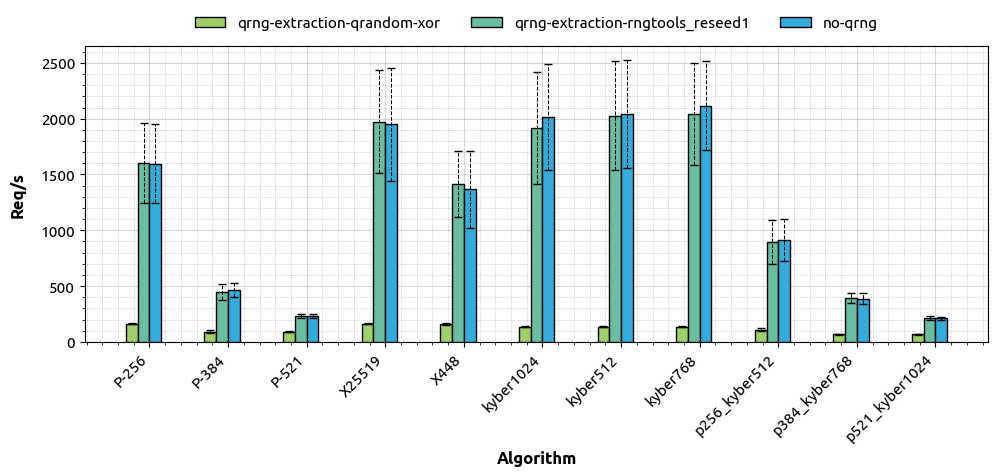

In [6]:
error_column = "Req/s_std"
#error_column = "Req/s_error"
if error_column == "Req/s_std":
    plot_title = f"{n_clients}_clients_{n_requests}_requests_openssl_vs_linux.png"
elif error_column == "Req/s_error":
    plot_title = f"{n_clients}_clients_{n_requests}_requests_openssl_vs_linux_std_error.png"
else:
    raise Exception("Invalid error column")
plot_req_s(summary_df_all, error_column=error_column, several_runs=True, xor_ratios=False, n_clients=n_clients, n_requests=n_requests, plot_title=plot_title)

#### Plotting QRNG integration modes Req/s comparison

In [7]:
qrng_openssl_modes_list =  ["qrng-extraction-qlib", "qrng-extraction-qlib-xor", "qrng-extraction-qrandom", "qrng-extraction-qrandom-xor"]
_, qrng_openssl_df_all = combine_summary_dataframes(n_clients, n_requests, qrng_openssl_modes_list, several_runs=True, n_runs = 100)
qrng_openssl_df_all.head()

,algorithm,mode,Req/s_mean,data/s_MB/s_mean,requests_total_mean,requests_started_mean,requests_done_mean,requests_succeeded_mean,requests_failed_mean,requests_errored_mean,...,data/s_MB/s_std,requests_total_std,requests_started_std,requests_done_std,requests_succeeded_std,requests_failed_std,requests_errored_std,requests_timeout_std,traffic_space_savings (%)_std,Req/s_error
0,P-256,qrng-extraction-qlib,109.6143,0.09,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051562
1,P-384,qrng-extraction-qlib,66.1790,0.05,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025769
2,P-521,qrng-extraction-qlib,66.1935,0.05,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022002
3,X25519,qrng-extraction-qlib,109.6202,0.09,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054063
4,X448,qrng-extraction-qlib,109.6020,0.09,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064692


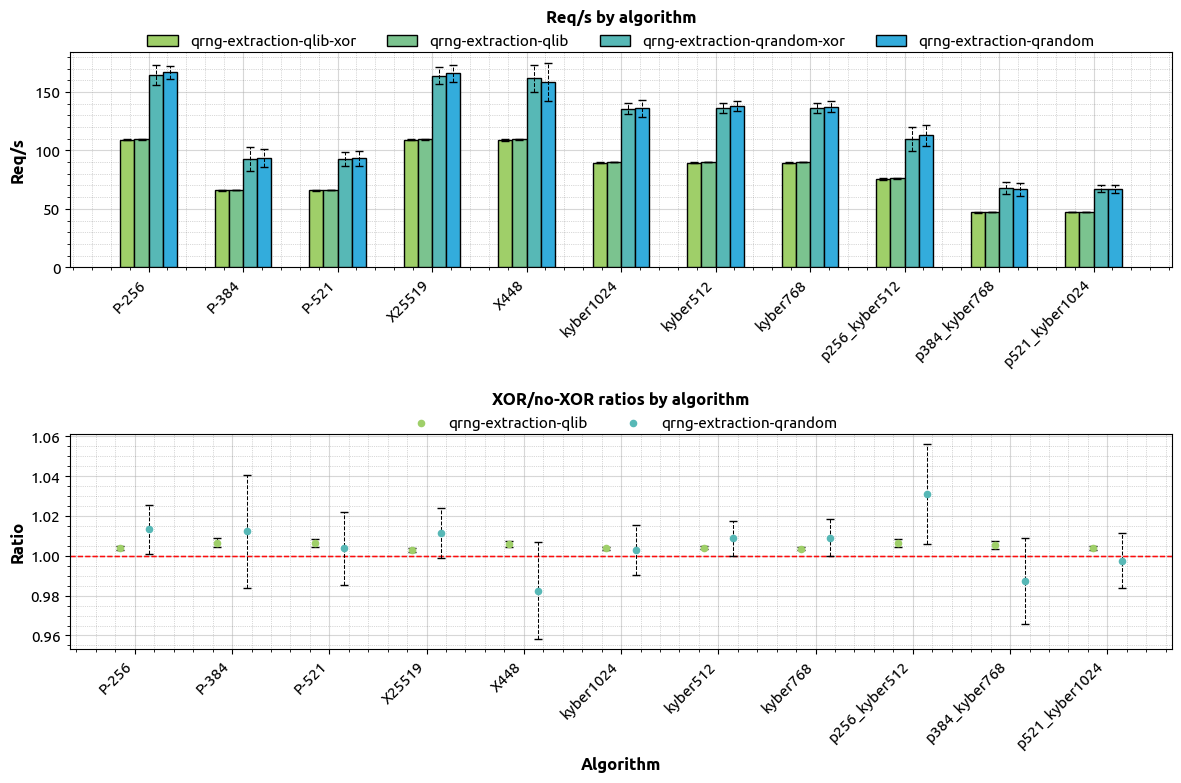

In [145]:
#error_column = "Req/s_std"
xor_ratios=True
error_column = "Req/s_std"
if error_column == "Req/s_std":
    if xor_ratios:
        plot_title = f"{n_clients}_clients_{n_requests}_openssl_comparison_xor_ratios.png"
    else:
        plot_title = f"{n_clients}_clients_{n_requests}_openssl_comparison.png"
elif error_column == "Req/s_error":
    if xor_ratios:
        plot_title = f"{n_clients}_clients_{n_requests}_openssl_comparison_xor_ratios_std_error.png"
    else:
        plot_title = f"{n_clients}_clients_{n_requests}_openssl_comparison_std_error.png"
else:
    raise Exception("Invalid error column")
plot_req_s(qrng_openssl_df_all, error_column=error_column, several_runs=True, xor_ratios=xor_ratios, n_clients=1000, n_requests=1000, plot_title=plot_title)

#### Computing the ratios between the QRNG and no-QRNG modes

In [27]:
def compute_ratios(summary_df_all, error_column="Req/s_error", confidence_level=0.95):

    no_qrng_data = summary_df_all[summary_df_all["mode"] == "no-qrng"]["Req/s_mean"]
    no_qrng_std = summary_df_all[summary_df_all["mode"] == "no-qrng"][error_column]

    ratios = []
    errors = []

    modes = summary_df_all["mode"].unique()
    modes = [mode for mode in modes if mode != "no-qrng"]

    # Compute the ratio and error for each mode
    for mode in modes:
        mode_data = summary_df_all[summary_df_all["mode"] == mode]["Req/s_mean"]
        mode_std = summary_df_all[summary_df_all["mode"] == mode][error_column]
        
        paired_data = zip(mode_data, no_qrng_data, mode_std, no_qrng_std)
        
        relative_diffs = []
        relative_errors = []
        
        for value_1, value_2, std_1, std_2 in paired_data:
            if value_1 != 0:
                ratio = value_2 / value_1
                error_ratio = ratio * ((std_1 / value_1) ** 2 + (std_2 / value_2) ** 2) ** 0.5
                
                relative_diffs.append(ratio)
                relative_errors.append(error_ratio)

        # Compute the t-value for the given confidence level and degrees of freedom
        t_value = t_dist.ppf((1 + confidence_level) / 2, len(relative_diffs) - 1)
        # Take the average of all relative differences and their errors
        average_ratio = sum(relative_diffs) / len(relative_diffs) if relative_diffs else 0
        #error_of_average = sum(relative_errors) / len(relative_errors) if relative_errors else 0
        error_of_average = (sum([error**2 for error in relative_errors]) / len(relative_errors))**0.5 if relative_errors else 0
        final_error = t_value * error_of_average
        
        ratios.append((mode, average_ratio, final_error))

    ratio_df = pd.DataFrame(ratios, columns=["mode", "Average Ratio", "Error"])

    ratio_df["Average Ratio"] = ratio_df["Average Ratio"].apply(lambda x: "{:.1f}".format(x))
    ratio_df["Error"] = ratio_df["Error"].apply(lambda x: "{:.1f}".format(x))

    return ratio_df

def create_table(ratio_df):

    headers = ["\\textbf{Mode}", "\\textbf{Average Ratio of Req/s}", "\\textbf{Error}"]
    headers_line = " & ".join(headers) + " \\\\ \\hline"
    latex_table = ratio_df.to_latex(index=False, column_format='|c|c|c|', escape=False, header=False)
    latex_table = latex_table.splitlines()
    latex_table.insert(1, headers_line)
    latex_table = "\\hline\n".join(latex_table[:-1]) + "\n" + latex_table[-1]

    caption = "\\caption{Ratios of Req/s between QRNG integration modes with respect to \\textit{no-qrng} mode}\n"
    label = "\\label{tab:ratios}\n"

    latex_table = '\\begin{table}[h]\n\\centering\n' + caption + label + latex_table + '\\end{table}'

    latex_table = latex_table.replace("qrng-extraction-", "")
    latex_table = latex_table.replace("qrandom-xor", '\\textbf{qrandom-xor}').replace("rngtools_reseed1", '\\textbf{rngtools\_reseed1}')

    return latex_table

In [28]:
ratio_df = compute_ratios(summary_df_all)
latex_table = create_table(ratio_df)

print(latex_table)
print(ratio_df)

\begin{table}[h]
\centering
\caption{Ratios of Req/s between QRNG integration modes with respect to \textit{no-qrng} mode}
\label{tab:ratios}
\begin{tabular}{|c|c|c|}\hline
\textbf{Mode} & \textbf{Average Ratio of Req/s} & \textbf{Error} \\ \hline\hline
\toprule\hline
\midrule\hline
\textbf{qrandom-xor} & 9.1 & 1.0 \\\hline
\textbf{rngtools\_reseed1} & 1.0 & 0.1 \\\hline
\bottomrule
\end{tabular}\end{table}
                               mode Average Ratio Error
0       qrng-extraction-qrandom-xor           9.1   1.0
1  qrng-extraction-rngtools_reseed1           1.0   0.1


### Connection, request and 1s byte times plots and calculations (timing dataframe)

In [173]:
# Function to generate color variations within a mode
def get_color(color_palette, mode_index, j, num_data_types):
    if j == num_data_types - 1:
        return color_palette[mode_index % len(color_palette)]
    color = color_palette[mode_index % len(color_palette)]
    alpha = 0.8
    delta = 0.125 * j
    modified_color = tuple(component + delta for component in mcolors.to_rgb(color))
    return (*modified_color, alpha)

def compute_error(df, n, std_column=None, confidence_level = 0.95):
    """
    Compute the error using t-student for a given dataframe and number of runs.
    """
    if std_column is None:
        raise Exception("std_column must be specified")
    
    sem = df[std_column] / np.sqrt(n)
    return sem.apply(lambda x: compute_t_error(x, n, confidence_level=0.95))

def propagate_t_error_for_avg(ses):
    """
    Propagate the error for the mean from individual standard errors.
    """
    return np.sqrt(np.sum(ses**2)) / len(ses)

def get_pooled_sd(df, mean_column, sd_column):
    """
    Compute the pooled standard deviation for a given dataframe.
    """
    mean_of_variances = np.mean(df[sd_column] ** 2)
    variance_of_means = np.var(df[mean_column])
    pooled_variance = mean_of_variances + variance_of_means
    pooled_sd = np.sqrt(pooled_variance)
    return pooled_sd

def get_stats(df):
    n_sample = len(df)
    output = {}
    if 'Mean' not in df or 'SD' not in df:
        mean_column = "Mean (s)"
        sd_column = "SD (s)"
    else:
        mean_column = "Mean"
        sd_column = "SD"

    individual_t_errors = compute_error(df, n_clients, std_column=sd_column)
    propagated_t_error = propagate_t_error_for_avg(individual_t_errors)

    if (df[sd_column] == 0).any():
        epsilon = 1e-10
        df[sd_column] = df[sd_column].replace(0, epsilon)

    output['weighted_mean'] = np.average(df[mean_column], weights=1 / (df[sd_column] ** 2))
    output['weighted_sd'] = np.sqrt(1 / np.sum(1 / (df[sd_column] ** 2)))
    output['weighted_t_error'] = compute_t_error(output['weighted_sd']/np.sqrt(n_sample), n_sample, confidence_level=0.95)
    output['avg_of_means'] = np.mean(df[mean_column])
    output['propagated_t_error'] = propagated_t_error
    output['pooled_sd'] = get_pooled_sd(df, mean_column, sd_column)
    # the effective sample size is the number of clients (assuming 1 request per client) times the number of runs
    output['pooled_t_error'] = compute_t_error(output['pooled_sd']/np.sqrt(n_sample*n_clients), n_sample*n_clients, confidence_level=0.95)

    return pd.Series(output, index=['weighted_mean', 'weighted_sd', 'weighted_t_error', 'avg_of_means', 'propagated_t_error', 'pooled_sd', 'pooled_t_error'])

def combine_timing_dataframes(n_clients, n_requests, modes_list, n_runs=10, error_calculation_method=None):

    timing_dfs = []

    for mode in modes_list:
        dir_name = f"{n_clients}_clients_{n_requests}_requests/{mode}-{n_runs}runs"
        if not os.path.isdir(os.path.join("..", "results", dir_name)):
            continue

        runs_dirs = [d for d in os.listdir(os.path.join("..", "results", dir_name)) if "run_" in d]
        
        for run_dir in runs_dirs:
            processed_dir_path = os.path.join("..", "results", dir_name, run_dir, "processed")
            for algorithm in os.listdir(processed_dir_path):
                timing_csv_path = os.path.join(processed_dir_path, algorithm, "timing_df.csv")
                if os.path.isfile(timing_csv_path):
                    timing_df = pd.read_csv(timing_csv_path)
                    timing_df["algorithm"] = algorithm
                    timing_df["mode"] = mode
                    timing_dfs.append(timing_df)
    # concatenate all dataframes in the list
    timing_df_all = pd.concat(timing_dfs, ignore_index=True)

    # Split timing_df into two dataframes, one for index=req/s and other for the remaining
    timing_df_all_reqs = timing_df_all[timing_df_all["index"] == "req/s"]
    timing_df_all = timing_df_all[timing_df_all["index"] != "req/s"]

    # The Min, Max, Mean and SD columns contain values of the form "xms" or "xus", remove the units, put the units in the column names and convert
    # all to miliseconds
    for column in ['Min', 'Max', 'Mean', 'SD']:
        # The value is of the form "xms" or "xus", remove the units, put the units in the column names and convert all to milliseconds
        timing_df_all[column] = timing_df_all[column].apply(convert_to_s)
        pass
    timing_df_all = timing_df_all.rename(columns={
        'Min': 'Min (s)',
        'Max': 'Max (s)',
        'Mean': 'Mean (s)',
        'SD': 'SD (s)'
    })
    timing_df_all_reqs['Mean'] = timing_df_all_reqs['Mean'].astype(float)
    timing_df_all_reqs['SD'] = timing_df_all_reqs['SD'].astype(float)
    # Calculating weighted mean and weighted SD for timing_df_all_reqs
    grouped_data_reqs = timing_df_all_reqs.groupby(['index', 'algorithm', 'mode'])
    timing_df_all_reqs = grouped_data_reqs.apply(error_calculation_method).reset_index()

    # Calculating aggregated Min and Max for timing_df_all_reqs
    aggregated_min_max_reqs = grouped_data_reqs.agg({'Min': 'min', 'Max': 'max'}).reset_index()
    timing_df_all_reqs = pd.merge(timing_df_all_reqs, aggregated_min_max_reqs, how='left', on=['index', 'algorithm', 'mode'], suffixes=('', '_agg'))

    # Calculating weighted mean and weighted SD for timing_df_all
    grouped_data_all = timing_df_all.groupby(['index', 'algorithm', 'mode'])
    timing_df_all = grouped_data_all.apply(error_calculation_method).reset_index()

    # Calculating aggregated Min and Max for timing_df_all
    aggregated_min_max_all = grouped_data_all.agg({'Min (s)': 'min', 'Max (s)': 'max'}).reset_index()
    timing_df_all = pd.merge(timing_df_all, aggregated_min_max_all, how='left', on=['index', 'algorithm', 'mode'], suffixes=('', '_agg'))

    return timing_df_all, timing_df_all_reqs

In [174]:
n_clients = 1000
n_requests = 1000
timing_modes_list = ["qrng-extraction-qrandom-xor", "qrng-extraction-rngtools_reseed1", "no-qrng"]
timing_df_all, timing_df_all_reqs  = combine_timing_dataframes(n_clients, n_requests, timing_modes_list, n_runs=100, error_calculation_method=get_stats)
timing_df_all.head()

,index,algorithm,mode,weighted_mean,weighted_sd,weighted_t_error,avg_of_means,propagated_t_error,pooled_sd,pooled_t_error,Min (s),Max (s)
0,time for connect,P-256,no-qrng,0.270847,0.009087,0.001803,0.308583,0.000711,0.157381,0.000975,0.05882,1.06
1,time for connect,P-256,qrng-extraction-qrandom-xor,1.111905,0.068831,0.013658,1.236515,0.006171,1.028527,0.006375,0.08316,6.84
2,time for connect,P-256,qrng-extraction-rngtools_reseed1,0.270072,0.009112,0.001808,0.307718,0.000712,0.155383,0.000963,0.05798,1.06
3,time for connect,P-384,no-qrng,1.246626,0.043495,0.008630,1.302300,0.002837,0.514854,0.003191,0.28746,2.92
4,time for connect,P-384,qrng-extraction-qrandom-xor,3.229942,0.188139,0.037331,3.266200,0.012153,1.966515,0.012189,0.28694,13.05


In [144]:
def plot_connection_times(input_df, mean_column="weighted_mean", sd_column="weighted_t_error", n_clients=None, n_requests=None, plot_tilte="connection_times.png"):

    fig, ax = plt.subplots(figsize=(12, 6))

    input_df = input_df.sort_values('algorithm')
    # remove algorithms containing the substrings "frodo", "bike" and "hqc" from the dataframe
    input_df = input_df[~input_df["algorithm"].str.contains("frodo|bike|hqc")]
    algorithms = input_df["algorithm"].unique()
    x = np.arange(len(algorithms))  # label locations
    unique_modes = input_df["mode"].unique()
    data_types = input_df["index"].unique()
    data_types = ["time for connect", "time to 1st byte"]

    color_palette = list(mcolors.LinearSegmentedColormap.from_list("", ["#9fcf69", "#33acdc"])(np.linspace(0, 1, 3)))

    width = 0.8  # width of the bars
    num_modes = len(unique_modes)
    num_data_types = len(data_types)
    bar_width = width / (num_modes * num_data_types)
    # sort data by mean value for the "Mean (s)" column
    unique_modes = sorted(unique_modes, key=lambda mode: input_df[input_df["mode"] == mode][mean_column].mean(), reverse=False)

    for i, mode in enumerate(unique_modes):
        for j, data_type in enumerate(data_types):
            mode_data = input_df[input_df["mode"] == mode]
            mode_data_type = mode_data[mode_data["index"] == data_type]

            # Shift bars and vary color slightly
            mode_color = get_color(color_palette, i, j, num_data_types)
            x_shift = x - width/2 + (j * bar_width) + (i * num_data_types * bar_width)

            container = ax.bar(
                x_shift,
                mode_data_type[mean_column],
                bar_width,
                label=f'{mode} {data_type}',
                color=mode_color,
                yerr=mode_data_type[sd_column],
                edgecolor='black',
                linewidth=1,
                zorder=3,
                capsize=2,
                error_kw={'ecolor': 'black'}
                )
            for line in container.errorbar.lines[2]:
                line.set_linestyle('dashed')
                line.set_linewidth(0.75)

    # Add legend at the top
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    num_legend_rows = int(np.ceil(len(legend_labels) / 3))
    ax.legend(
        handles=legend_handles,
        labels=legend_labels,
        fontsize=11,
        loc='upper center',
        ncol=3,
        bbox_to_anchor=(0.5, 1.15),
        frameon=False
        )

    ax.set_ylabel('Time (s)',
                weight='bold',
                fontsize=12,
                )
    ax.yaxis.set_label_coords(-0.04, 0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms, rotation=45, horizontalalignment='right')
    ax.tick_params(axis='both', labelsize=11)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel('Algorithm', weight='bold', fontsize=12)
    ax.grid(True, zorder=0, alpha=0.5)
    ax.grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)
    plt.tight_layout()

    if not os.path.isdir("./plots"):
        os.mkdir("./plots")
    plt.savefig(os.path.join(".", "plots", plot_title))
    plt.show()

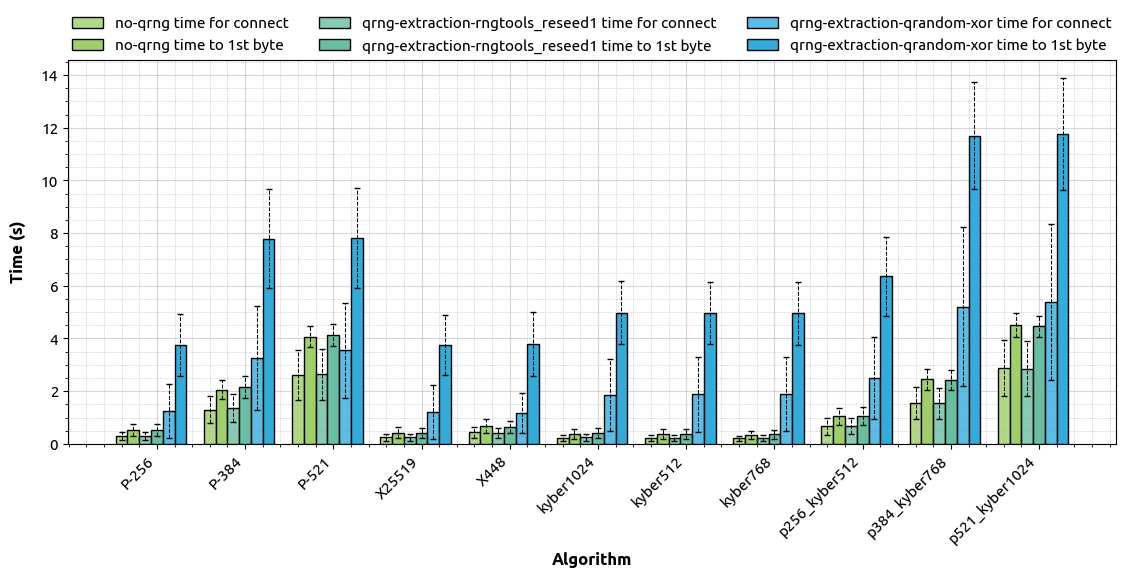

In [175]:
plot_title=f"{n_clients}_clients_{n_requests}_requests_connection_and_1st_byte_times.png"
#plot_connection_times(timing_df_all, mean_column="weighted_mean", sd_column="weighted_sd", n_clients=n_clients, n_requests=n_requests, plot_tilte=plot_title)
plot_connection_times(timing_df_all, mean_column="avg_of_means", sd_column="pooled_sd", n_clients=n_clients, n_requests=n_requests, plot_tilte=plot_title)
#plot_connection_times(timing_df_all, mean_column="avg_of_means", sd_column="pooled_t_error", n_clients=n_clients, n_requests=n_requests, plot_tilte=plot_title)
#plot_connection_times(timing_df_all, mean_column="avg_of_means", sd_column="propagated_t_error", n_clients=n_clients, n_requests=n_requests, plot_tilte=plot_title)
#plot_connection_times(timing_df_all, mean_column="weighted_mean", sd_column="weighted_t_error", n_clients=n_clients, n_requests=n_requests, plot_tilte=plot_title)

#### Ratios between connection and 1st byte times ratios with respect to no-qrng mode

In [37]:
def plot_connection_times_ratios(input_df, n_clients=None, n_requests=None, plot_title="times_ratios.png"):
    mean_column = "weighted_mean"
    sd_column = "weighted_sd"
    mean_column = "avg_of_means"
    sd_column = "propagated_error"

    fig, ax = plt.subplots(figsize=(12, 6))

    ratio_df = pd.DataFrame(columns=['mode', 'data_type', 'ratio', 'error'])

    no_qrng_data = input_df[input_df["mode"] == "no-qrng"]
    unique_modes = input_df["mode"].unique()
    data_types = ["time for connect", "time to 1st byte"]

    for mode in unique_modes:
        if mode != "no-qrng":  # Skip the "no-qrng" mode
            for data_type in data_types:
                # Get the data for the current mode and data type
                mode_data = input_df[(input_df["mode"] == mode) & (input_df["index"] == data_type)]
                no_qrng_data_type = no_qrng_data[no_qrng_data["index"] == data_type]

                # Calculate the ratio
                ratio = mode_data[mean_column].values / no_qrng_data_type[mean_column].values

                # Propagate the errors
                error = abs(ratio) * np.sqrt(
                    (mode_data[sd_column].values / mode_data[mean_column].values) ** 2 +
                    (no_qrng_data_type[sd_column].values / no_qrng_data_type[mean_column].values) ** 2
                )

                row_data = pd.DataFrame({'mode': [mode], 'data_type': [data_type], 'ratio': [ratio[0]], 'error': [error[0]]})
                ratio_df = pd.concat([ratio_df, row_data], ignore_index=True)

    unique_modes = ratio_df["mode"].unique()[::-1]
    x = np.arange(len(unique_modes))  # label locations

    color_palette = list(mcolors.LinearSegmentedColormap.from_list("", ["#9fcf69", "#33acdc"])(np.linspace(0, 1, 2)))

    width = 0.8  # width of the bars
    num_data_types = len(data_types)
    bar_width = width / num_data_types
    # remove "no-qrng" from the list of modes
    unique_modes = [mode for mode in unique_modes if mode != "no-qrng"]
    for i, mode in enumerate(unique_modes):
        for j, data_type in enumerate(data_types):
            mode_data_type = ratio_df[(ratio_df["mode"] == mode) & (ratio_df["data_type"] == data_type)]

            # Shift bars and vary color slightly
            mode_color = get_color(color_palette, i, j, num_data_types)
            x_shift = i - width/2 + (j * bar_width)

            container = ax.bar(
                x_shift,
                mode_data_type["ratio"],
                bar_width,
                label=f'{mode} {data_type}',
                color=mode_color,
                yerr=mode_data_type["error"],
                edgecolor='black',
                linewidth=1,
                zorder=3,
                capsize=2,
                error_kw={'ecolor': 'black'}
                )
            for line in container.errorbar.lines[2]:
                line.set_linestyle('dashed')
                line.set_linewidth(0.75)

    # Add legend at the top
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    num_legend_rows = int(np.ceil(len(legend_labels) / 3))
    ax.legend(
        handles=legend_handles,
        labels=legend_labels,
        fontsize=11,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, 1.25),
        frameon=False
        )

    ax.set_ylabel('Ratio', weight='bold', fontsize=12)
    ax.yaxis.set_label_coords(-0.04, 0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(unique_modes, horizontalalignment='right')
    ax.tick_params(axis='both', labelsize=11)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel('Mode', weight='bold', fontsize=12)
    ax.grid(True, zorder=0, alpha=0.5)
    ax.grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)
    plt.tight_layout()
    if not os.path.isdir("./plots"):
        os.mkdir("./plots")
    plt.savefig(os.path.join(".", "plots", plot_title))
    plt.show()

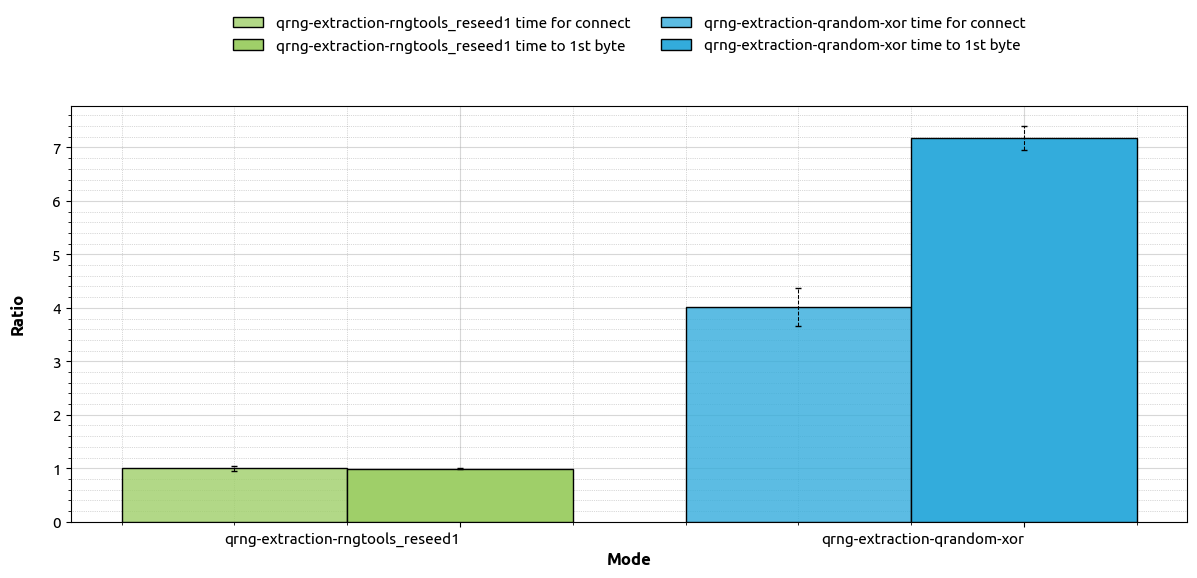

In [38]:
plot_title = f"{n_clients}_clients_{n_requests}_requests_connection_and_1st_byte_times_ratios.png"
plot_connection_times_ratios(timing_df_all, n_clients=n_clients, n_requests=n_requests)